In [1]:
import sys
sys.path.append('..')
sys.path.append('../..')

In [2]:
import os
from os import path
import torch
from torch.utils.data import DataLoader
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

In [3]:
from Pytorch.utils import Denormalize_tensor, Show_figure_with_bbox

In [4]:
exp_name = "Benedettini-DoubleROIClassification-RN50+RN18-SGD-2"
epochs = 120
batch_size = 56
num_batch_train = 200
num_batch_val = 80
img_size = 280

In [5]:
parameters_path = path.join("parameters", exp_name)
plots_path = path.join("plots", exp_name)

In [6]:
import torch
from torch.utils.data import Dataset
from PIL import Image
from os import path
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

import cv2
from albumentations import Compose, Normalize, VerticalFlip, HorizontalFlip, Rotate, Resize, LongestMaxSize, PadIfNeeded, BboxParams
from albumentations.pytorch import ToTensor, ToTensorV2

from Pytorch.utils import Normalize_bbox_to_0_1, Convert_bbox_from_TLWH_to_TLBR, clamp

'''
CODING CONVENTIONS

- All names use underscore casing
- L_* for list variable names
- D_* for dictionary variable names
- T_* for tensor variable names
- M_* for Pytorch models
- DL_* for Data Loader
- DSET_* for Dataset
- Class names are in upper case
- Function names start with a capital letter
'''

AlbuToNormalizedTensor_transform = Compose(
    [
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

def AlbuToNormalizedTensor(image):
    return AlbuToNormalizedTensor_transform(image=image)['image']

class CONTEXT_DATASET(Dataset):
    def __init__(self,
                root_dirpath,
                images_dirpath,
                annotations_path,
                image_id_key="image_id",
                category_id_key="category_id",
                F_image_id_to_relative_path=None,
                augmentation=True,
                desired_size=224,
                batch_size=12,
                num_batch=1):

        self.root_dirpath = root_dirpath
        self.images_dirpath = images_dirpath
        self.annotations_path = annotations_path
        self.image_id_key=image_id_key
        self.category_id_key=category_id_key
        self.F_image_id_to_relative_path = F_image_id_to_relative_path
        self.augmentation = augmentation
        self.desired_size = desired_size
        self.batch_size = batch_size
        self.num_batch = num_batch

        with open(self.annotations_path) as f:
            self.D_instances = json.load(f)
            self.L_annotations = self.D_instances['annotations']
            self.L_categories = self.D_instances['categories']

        # list of real class indices in COCO dataset
        self.L_real_class_idx = [x['id'] for x in self.L_categories]
        # zero-based class indices of COCO dataset (0-79)
        self.L_class_idx = range(len(self.L_real_class_idx))
        # dict to map real class indices to zero-based indices
        self.D_real_class_idx_to_class_idx = { real_class_idx : class_idx for class_idx, real_class_idx in enumerate(self.L_real_class_idx)}

        # dict to map zero based indices to the relative annotations
        self.D_class_to_annotations = self.Create_class_to_annotations_dict()

        # filter zero-based class indices which have no annotations
        self.L_not_empty_class_idx = [class_idx for class_idx in self.L_class_idx if len(self.D_class_to_annotations[class_idx])>0]

        bbox_params = BboxParams(format='coco', label_fields=[self.category_id_key])
        self.augmentation_transform = Compose(
            [
                VerticalFlip(p=0.5),
                HorizontalFlip(p=0.5),
                LongestMaxSize(max_size=600),
                PadIfNeeded(min_height=710, min_width=710, border_mode=cv2.BORDER_CONSTANT),
                Rotate(p=1.0, limit=12, interpolation=cv2.INTER_LINEAR, border_mode=cv2.BORDER_CONSTANT),
                #Resize(height=desired_size, width=desired_size),
            ],
            bbox_params=bbox_params)
        
        self.last_resize_transform = Resize(height=desired_size, width=desired_size)

        self.loading_transform = Compose(
            [
                LongestMaxSize(max_size=desired_size),
                PadIfNeeded(min_height=desired_size, min_width=desired_size, border_mode=cv2.BORDER_CONSTANT),
            ],
            bbox_params=bbox_params)

        self.transform = self.augmentation_transform if self.augmentation else self.loading_transform

    def Create_class_to_annotations_dict(self):
        '''
        Create a dictionary of type (int : list) which map to each zero-based class index a list of
        all the COCO annotations of a specific class using self.D_real_class_idx_to_class_idx as map
        '''
        # init empty dictionary with zero-based class indices
        D_class_to_annotations = {idx : [] for idx in self.L_class_idx}

        for annotation in self.L_annotations:
            real_class_idx = annotation[self.category_id_key]
            class_idx = self.D_real_class_idx_to_class_idx[real_class_idx]
            D_class_to_annotations[class_idx].append(annotation)

        return D_class_to_annotations

    def Get_num_classes(self):
        return len(self.L_categories)

    def Get_class_idx_description(self, class_idx):
        return self.L_categories[class_idx]

    def __getitem__(self, index):
        try:
            # sample a random annotation from a random class
            item_class_idx = np.random.choice(self.L_not_empty_class_idx)
            D_item_annotation = np.random.choice(self.D_class_to_annotations[item_class_idx])

            item_image_id = D_item_annotation[self.image_id_key]

            if(self.F_image_id_to_relative_path):
                image_relative_path = self.F_image_id_to_relative_path(item_image_id)
            else:
                image_relative_path = item_image_id
            item_PIL_image = Image.open(path.join(self.images_dirpath, image_relative_path)).convert('RGB')
            image_width, image_height = item_PIL_image.size

            item_bbox = D_item_annotation['bbox']
            item_bbox[0] = clamp(item_bbox[0], 0, image_width)
            item_bbox[1] = clamp(item_bbox[1], 0, image_height)
            item_bbox[2] = clamp(item_bbox[2], 0, image_width-item_bbox[0])
            item_bbox[3] = clamp(item_bbox[3], 0, image_height-item_bbox[1])

            D_item_albumentation = {'image': np.array(item_PIL_image), 'bboxes': [item_bbox], self.category_id_key: [item_class_idx]}

            D_item_transformed = self.transform(**D_item_albumentation)
            if(len(D_item_transformed['bboxes'])==0):
                return self[0]

            # D_item_transformed['bboxes'] has got the only bbox we are passing in D_item_albumentation
            L_bbox_TLBR = Convert_bbox_from_TLWH_to_TLBR(list(D_item_transformed['bboxes'][0]))
            L_bbox_normalized = Normalize_bbox_to_0_1(L_bbox_TLBR, (710, 710))
            T_bbox_normalized = torch.Tensor(L_bbox_normalized)
            
            augmented_image = D_item_transformed["image"]
            L_bbox_TLBR = [int(x) for x in L_bbox_TLBR]
            cropped_image = augmented_image[L_bbox_TLBR[1]:L_bbox_TLBR[3], L_bbox_TLBR[0]:L_bbox_TLBR[2]]
            cropped_image = self.loading_transform(**{'image': cropped_image, 'bboxes': [], self.category_id_key: []})['image']
            augmented_image_resize=self.last_resize_transform(image=augmented_image)["image"]
            return (AlbuToNormalizedTensor(cropped_image), AlbuToNormalizedTensor(augmented_image_resize)), item_class_idx
        except:
            return self[0]

    def __len__(self):
        return self.num_batch*self.batch_size



In [7]:
DSET_training = CONTEXT_DATASET(
    root_dirpath = '../../../Datasets/Points Of Interest Recognition/Monastero dei Benedettini/',
    images_dirpath = '../../../Datasets/Points Of Interest Recognition/Monastero dei Benedettini/',
    annotations_path = '../../../Datasets/Points Of Interest Recognition/Monastero dei Benedettini/train_dataset.json',
    image_id_key="path",
    category_id_key="class_id",
    augmentation=True,
    batch_size=batch_size,
    num_batch=num_batch_train,
    desired_size=img_size,
)

In [8]:
DSET_validation = CONTEXT_DATASET(
    root_dirpath = '../../../Datasets/Points Of Interest Recognition/Monastero dei Benedettini/',
    images_dirpath = '../../../Datasets/Points Of Interest Recognition/Monastero dei Benedettini/',
    annotations_path = '../../../Datasets/Points Of Interest Recognition/Monastero dei Benedettini/val_dataset.json',
    image_id_key="path",
    category_id_key="class_id",
    augmentation=False,
    batch_size=batch_size,
    num_batch=num_batch_val,
    desired_size=img_size,
)

In [9]:
denormalize_func = Denormalize_tensor(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

In [10]:
(T_img, T_context), class_idx = DSET_training[0]

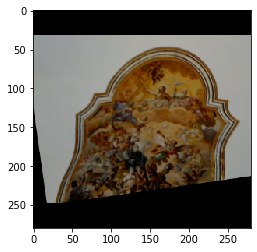

In [11]:
plt.imshow(transforms.ToPILImage()(denormalize_func(T_img)))

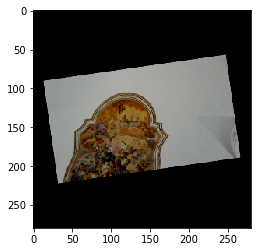

In [12]:
plt.imshow(transforms.ToPILImage()(denormalize_func(T_context)))

In [13]:
(T_img, T_context), class_idx = DSET_validation[0]

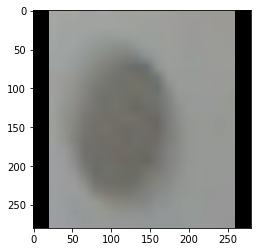

In [14]:
plt.imshow(transforms.ToPILImage()(denormalize_func(T_img)))

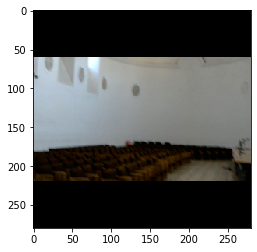

In [15]:
plt.imshow(transforms.ToPILImage()(denormalize_func(T_context)))

In [16]:
DL_training = DataLoader(DSET_training, batch_size=batch_size, shuffle=False)
DL_validation = DataLoader(DSET_validation, batch_size=batch_size, shuffle=False)

In [17]:
from torchvision.models import resnet50
from torchvision.models import resnet18

class M_CONTEXT_CLASSIFIER(torch.nn.Module):
    def __init__(self, num_classes, backbone=None):
        super(M_CONTEXT_CLASSIFIER, self).__init__()

        self.num_classes = num_classes
        self.M_context_cnn = resnet18(pretrained=True)
        self.M_context_cnn.fc = torch.nn.Linear(in_features=self.M_context_cnn.fc.in_features, out_features=512, bias=True)
        
        self.M_patch_cnn = resnet50(pretrained=True)
        self.M_patch_cnn.fc = torch.nn.Identity()
        
        self.fc = torch.nn.Linear(in_features=2048+self.M_context_cnn.fc.out_features, out_features=self.num_classes, bias=True)

    def forward(self, inputs):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        T_image, T_context = inputs
        T_extracted_features_patch = self.M_patch_cnn(T_image)
        T_extracted_features_context = self.M_context_cnn(T_context)
        T_features = torch.cat((T_extracted_features_patch, T_extracted_features_context), 1)
        return self.fc(T_features)

In [18]:
M_classifier = M_CONTEXT_CLASSIFIER(num_classes=DSET_training.Get_num_classes())
M_classifier = M_classifier.to('cuda')

In [19]:
def prepare_batch_fn(batch, gt):
    gt = gt.long()
    return batch, gt

In [20]:
from torchtrainer.trainer import Trainer, Mode
from torchtrainer.callbacks.calculate_accuracy_callback import CalculateTopNAccuracyCallback
from torchtrainer.callbacks.calculate_loss_callback import CalculateLossCallback
from torchtrainer.callbacks.plot_callback import PlotCallback
from torchtrainer.callbacks.save_parameters_callback import SaveParametersCallback
from torchtrainer.callbacks.set_tqdm_bar_description_callback import SetTQDMBarDescriptionCallback
from torchtrainer.callbacks.lr_batch_scheduler_callback import LRBatchSchedulerCallBack
from torchtrainer.callbacks.calculate_accuracy_per_class_callback import CalculateAccuracyPerClassCallback
from torchtrainer.callbacks.plot_accuracy_per_class_callback import PlotAccuracyPerClassCallback

In [21]:
optimizer = torch.optim.SGD(M_classifier.parameters(), lr = 0.1, momentum = 0.12)
criterion = torch.nn.CrossEntropyLoss()

In [22]:
trainer = Trainer(
    device = 'cuda',
    modes = [Mode.TRAIN, Mode.EVALUATE],
    model = M_classifier,
    data_loaders = {Mode.TRAIN : DL_training, Mode.EVALUATE : DL_validation},
    epochs = epochs,
    starting_epoch = 0,
    optimizer = optimizer,
    criterion = criterion,
    prepare_batch_fn = prepare_batch_fn,
    callbacks = [
        CalculateLossCallback(key='Loss'),
        CalculateTopNAccuracyCallback(keys=('Top-1 accuracy',), topk=(1,)),
        CalculateAccuracyPerClassCallback(DSET_training.Get_num_classes()),
        PlotCallback(plots_path, labels_map={Mode.TRAIN:"Train", Mode.EVALUATE:"Val"}, columns=['Loss', 'Top-1 accuracy']),
        PlotAccuracyPerClassCallback(DSET_training.Get_num_classes(), plots_path),
        SetTQDMBarDescriptionCallback(keys=['Loss', 'Top-1 accuracy']),
        SaveParametersCallback(parameters_path),
    ]
)

In [ ]:
trainer.start()

Epoch 0


Loss = 1.0315 Top-1 accuracy = 73.8636 :  38%|███▊      | 77/200 [04:41<07:27,  3.64s/it]

In [ ]:
from torch_lr_finder import LRFinder

In [ ]:
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
optimizer = torch.optim.SGD(M_classifier.parameters(), lr=1e-7, momentum=0.0)
lr_finder = LRFinder(M_classifier, optimizer, criterion, device="cuda")
lr_finder.range_test(DL_training, end_lr=2, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [ ]:
optimizer = torch.optim.SGD(M_classifier.parameters(), lr=1e-7, momentum=0.2)
lr_finder = LRFinder(M_classifier, optimizer, criterion, device="cuda")
lr_finder.range_test(DL_training, end_lr=2, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [ ]:
optimizer = torch.optim.SGD(M_classifier.parameters(), lr=1e-7, momentum=0.6)
lr_finder = LRFinder(M_classifier, optimizer, criterion, device="cuda")
lr_finder.range_test(DL_training, end_lr=2, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state